## Template to read and plot 2D Cubed Sphere data.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
from scipy.interpolate import griddata

In [5]:
file_path='../data/sample_CS2d.nc4'

#data_variable='MASS'
data_variable='QV'

/Users/goktas/miniconda3/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


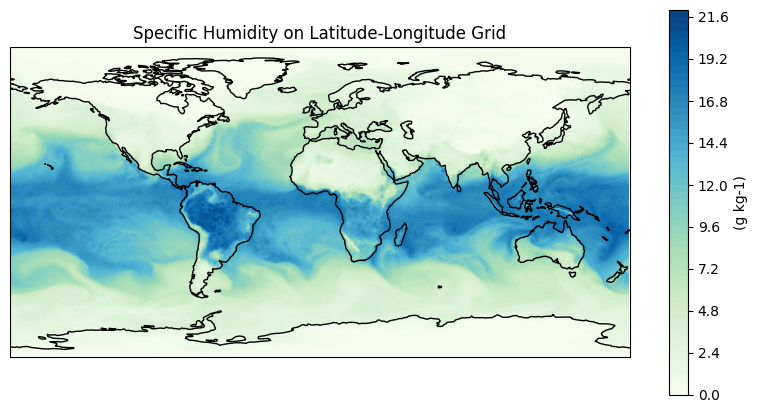

In [6]:
def read_cubed_sphere_data(file_path):
    dataset = Dataset(file_path, 'r')

#    data = dataset.variables['MASS'][:]  # Atmospheric mass data  MASS(time, nf, Ydim, Xdim)
    data = dataset.variables['QV'][:,0,:,:]  # Specific humidity QV(time, lev, nf, Ydim, Xdim) ; lev =1 
    lons = dataset.variables['lons'][:]
    lats = dataset.variables['lats'][:]

    dataset.close()
    return data, lons, lats

def adjust_longitudes(lons):
    lons = np.where(lons > 180, lons - 360, lons)
    return lons

def interpolate_to_latlon_grid(lat, lon, data, resolution=1.0):
    lat_grid = np.arange(-90, 90 + resolution, resolution)
    lon_grid = np.arange(-180, 180 + resolution, resolution)
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

    data_grid = griddata((lat.flatten(), lon.flatten()), data.flatten(), (lat_grid, lon_grid), method='linear')

    return lat_grid, lon_grid, data_grid

def plot_data(lat_grid, lon_grid, data_grid):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    plt.contourf(lon_grid, lat_grid, data_grid*1e+3, 60, transform=ccrs.PlateCarree(), cmap='GnBu')
#    plt.colorbar(label='Atmospheric Mass (kg m-2)')
    plt.colorbar(label='(g kg-1)')
    plt.title('Specific Humidity on Latitude-Longitude Grid')
    plt.show()

def main(file_path):
    data, lons, lats = read_cubed_sphere_data(file_path)
    
    lons = adjust_longitudes(lons)

    all_lat = []
    all_lon = []
    all_data = []

    for face_index in range(data.shape[1]):  # Loop over each face
        face_data = data[0, face_index, :, :]  # Assuming time index 0 and one vertical level
        face_lons = lons[face_index, :, :]
        face_lats = lats[face_index, :, :]

        all_lat.append(face_lats)
        all_lon.append(face_lons)
        all_data.append(face_data)

    # Combine all faces into single arrays
    lat = np.concatenate([lat.flatten() for lat in all_lat])
    lon = np.concatenate([lon.flatten() for lon in all_lon])
    data = np.concatenate([d.flatten() for d in all_data])

    lat_grid, lon_grid, data_grid = interpolate_to_latlon_grid(lat, lon, data)
    plot_data(lat_grid, lon_grid, data_grid)

if __name__ == "__main__":
    file_path='../data/sample_CS2d.nc4'
    main(file_path)